In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from numpy import linalg as LA

In [176]:
def disk(r):
    k=np.zeros((r,r))
    for i in range(0,r):
        for j in range(0,r):
            if((i-r//2)**2+(j-r//2)**2 <= (r//2)**2):
                k[i][j]=1
    return k

def chkMatch(img,filt):
    [x,y]=img.shape
    for i in range(0,x):
        for j in range(0,y):
            if(filt[i][j]!=0 and filt[i][j]!=img[i][j]):
                return -1
    return 1

def erosion(img,filt):
    [a,b]=img.shape
    [x,y]=filt.shape
    out=img.copy()
    for i in range(x//2,a-x//2):
        for j in range(y//2,b-y//2):
            a=chkMatch(img[i-x//2:i+1+x//2,j-x//2:j+1+x//2],filt)
            if(a==1):
                out[i][j]=255
            else :
                out[i][j]=0
    return out

def chkMatchD(img,filt):
    [x,y]=img.shape
    #print(img)
    #print(filt)
    for i in range(0,x):
        for j in range(0,y):
            if(filt[i][j]!=0 and filt[i][j]==img[i][j]):
                return 1
    return -1

def dilution(img,filt):
    [a,b]=img.shape
    [x,y]=filt.shape
    out=img.copy()
    for i in range(x//2,a-x//2):
        for j in range(y//2,b-y//2):
            a=chkMatchD(img[i-(x//2):i+1+(x//2),j-(x//2):j+1+(x//2)],filt)
            if(a==1):
                out[i][j]=1
            else :
                out[i][j]=0
    return out*255

In [253]:
# Function to read Images

def readImage(path):
    img=Image.open(path).convert('L')
    return img

# Function to find Homography between two images

def getHomography(img1,img2):
    orig_image = np.array(img1)
    skewed_image = np.array(img2)
    try:
        surf = cv2.xfeatures2d.SURF_create(500)
    except Exception:
        surf = cv2.SIFT(500)
    kp1,des1 = surf.detectAndCompute(orig_image, None)
    kp2,des2 = surf.detectAndCompute(skewed_image, None)
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H
# Function to get initial set of points along with distribution of the options

def makePoints():
    a=[[100,124],[134,124],[166,124],
       [100,145],[134,145],[166,145],
       [100,169],[134,169],[166,169],
       [100,191],[134,191],[166,191],
       [100,212],[134,212],[166,212],[202,212],[235,212],
       [100,234],[134,234],
       [101,257],[134,257],
       [101,279],[134,279],
       [101,302],[134,302],[168,302],
       [101,324],[135,324],[168,324]]
    d=[3,3,3,3,5,2,2,2,3,3]
    return a,d

# Fuction to gets corresponding points if H is known

def getsCorrspondingPoints(points,H):
    points=np.array(points)
    x=points.shape[0]
    point=np.hstack((points,np.ones((x,1))))
    point=point.T
    #print(H.shape)
    #print(point.shape)
    correspondingPoints=np.matmul(H,point)
    correspondingPoints=correspondingPoints.T
    for i in range(0,x):
        correspondingPoints[i][0]=correspondingPoints[i][0]/correspondingPoints[i][2]
        correspondingPoints[i][1]=correspondingPoints[i][1]/correspondingPoints[i][2]
    return correspondingPoints

# Function to check for answers in the sheet if points known

def checkNeighboursPixels(img,points):
    img=np.array(img)
    points=np.array(points)
    points=points.astype('int')
    binaryImg=(img<200).astype(np.uint8)
    kernel=np.ones((5,5),np.uint8)
    binaryImg=cv2.morphologyEx(binaryImg,cv2.MORPH_OPEN,kernel)
    #binaryImg=binaryImg*255
    plt.figure(figsize=(15,15))
    plt.imshow(binaryImg,cmap='gray')
    plt.scatter(points[:,0],points[:,1])
    x=points.shape[0]
    n=5
    print(points[0,0],points[0,1])
#     plt.figure(figsize=(15,15))
#     plt.imshow(binaryImg[80:150,50:250],cmap='gray')
    answers=np.zeros(x)
    for i in range(0,x):
        ans=0
        for j in range(points[i,0]-n,points[i,0]+n):
            for k in range(points[i,1]-n,points[i,1]+n):
                #plt.scatter(j,k)
                if(binaryImg[k][j]):
                    ans+=1
        answers[i]=ans
    answers=answers>0
    return answers.astype('int')

# Function to gets the answers between two given sheets

def getAnswers(img1,img2,points):
    homography=getHomography(img1,img2)
    correspondingPoints=getsCorrspondingPoints(points,homography)
    plt.figure(figsize=(15,15))
    plt.imshow(np.array(img2),cmap='gray')
    plt.scatter(correspondingPoints[:,0],correspondingPoints[:,1])
    plt.show()
    answer=checkNeighboursPixels(img2,correspondingPoints)
    return answer
    
def calculateScore(o,y,distribution):
    idd=0
    distribution=np.array(distribution)
    wrong=[]
    right=[]
    for i in range(0,distribution.shape[0]):
        j=0
        for k in range(0,distribution[i]):
            if(o[idd]!=y[idd] and j==0):
                wrong.append(i+1)
                j=1
            idd+=1
        if j==0:
            right.append(i+1)            
    return right,wrong

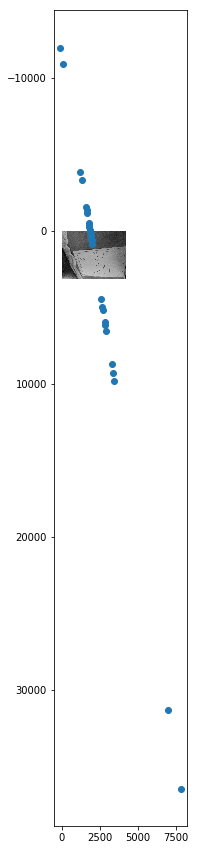

1874 42


IndexError: index -3865 is out of bounds for axis 0 with size 3120

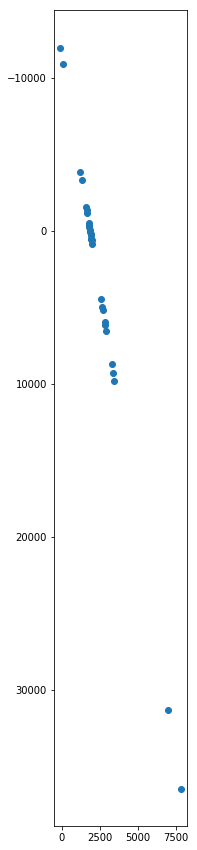

In [261]:
path1='./i1.jpeg'
path2='./i2.jpeg'
path3='./IMG_20191123_150855777_BURST012.jpg'

templateImg=readImage(path1)
anskeyImg=readImage(path2)
testImg=readImage(path3)

ansCordinates,distribution=makePoints()

#originalAnswers=getAnswers(templateImg,anskeyImg,ansCordinates)
testAnswers=getAnswers(tempelateImg,testImg,ansCordinates)

right,wrong=calculateScore(originalAnswers,testAnswers,distribution)
print(originalAnswers)
print(testAnswers)
print(right)
print(wrong)